<h1 style="padding-top: 25px;padding-bottom: 25px;text-align: left; padding-left: 10px; background-color: #DDDDDD; 
    color: black;"> <img style="float: left; padding-right: 10px;" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png" height="50px"> <a href='https://harvard-iacs.github.io/2021-AC215/' target='_blank'><strong><font color="#A41034">AC215: Advanced Practical Data Science, MLOps</font></strong></a></h1>

# **<font color="#A41034">Exercise 3 - Mushroom Identification Models</font>**

**Harvard University**<br/>
**Fall 2021**<br/>
**Instructor:**<br/>
Pavlos Protopapas

<hr style="height:2pt">

## **<font color="#A41034">Competition</font>**

### **<font color="#f03b20">Due Date: Check Canvas</font>**

#### **[View Leaderboard](http://ac215-leaderboard.dlops.io/)**

Now your task for this exercise is to build the best model for mushroom classification. You are free to use any techniques. Here are some techniques you can try:

* Data augmentation
* Hyper parameters tuning
* Transfer Learning using different pre-trained models
* Learning rate schedulers
* Early stopping
* etc...

#### **Exercise Requirements:**
* Create TF Records to build your data pipelines
* Perform model compression using Distillation
* Perform model compression using Pruning

You can submit as many models as you want with any techniques used but make sure to keep your work based on the above requirements before you submit your notebook on canvas

<br>

**Remember to submit your experiments to the cloud storage bucket using the code provided and also submit your notebook to Canvas**

<br>

**<font color="#f03b20">Leaderboard for this competition will be computed based on `hidden` test set. Winner gets a $50 Amazon gift card from Pavlos</font>**

## **<font color="#A41034">Setup Notebook</font>**

**Copy & setup Colab with GPU**

1) Select "File" menu and pick "Save a copy in Drive"  
2) This notebooks is already setup to use GPU but if you want to change it. Go to "Runtime" menu and select "Change runtime type". Then in the popup in "Hardware accelerator" select "GPU" and then click "Save"   
3) If you want high RAM there is an option for that

**Imports**

In [1]:
import os
import requests
import zipfile
import tarfile
import shutil
import math
import json
import time
import sys
import cv2
import string
import re
import subprocess
import hashlib
import numpy as np
import pandas as pd
from glob import glob
import collections
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params

# sklearn
from sklearn.model_selection import train_test_split

# Tensorflow Hub
import tensorflow_hub as hub

# TF Optimization
!pip install tensorflow_model_optimization
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity.keras import prune_low_magnitude

# Colab auth
from google.colab import auth
from google.cloud import storage

     |████████████████████████████████| 213 kB 5.3 MB/s 


**Verify Setup**

It is a good practice to verify what version of TensorFlow & Keras you are using. Also verify if GPU is enabled and what GPU you have. Run the following cells to check the version of TensorFlow

References:
- [Eager Execution](https://www.tensorflow.org/guide/eager)
- [Data Performance](https://www.tensorflow.org/guide/data_performance)

In [2]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.6.0
keras version 2.6.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Run this cell to see what GPU you have. If you get a P100 or T4 GPU that's great. If it's K80, it will still work but it will be slow.

In [3]:
!nvidia-smi

Mon Oct  4 23:40:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    60W / 149W |    123MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Utils**

Here are some util functions that we will be using for this notebook

In [99]:
def download_file(packet_url, base_path="", extract=False, headers=None):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True, headers=headers) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)
  
  if extract:
    if packet_file.endswith(".zip"):
      with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)
    else:
      packet_name = packet_file.split('.')[0]
      with tarfile.open(os.path.join(base_path,packet_file)) as tfile:
        tfile.extractall(base_path)

def compute_dataset_metrics(data_list):
  data_list_with_metrics = []
  for item in data_list:
    # Read image
    image = cv2.imread(item[1])
    data_list_with_metrics.append((item[0],item[1],image.shape[0],image.shape[1],image.nbytes / (1024 * 1024.0)))

  # Build a dataframe
  data_list_with_metrics = np.asarray(data_list_with_metrics)
  dataset_df = pd.DataFrame({
    'label': data_list_with_metrics[:, 0], 
    'path': data_list_with_metrics[:, 1],
    'height': data_list_with_metrics[:, 2],
    'width': data_list_with_metrics[:, 3],
    'size': data_list_with_metrics[:, 4],
    })
  
  dataset_df["height"] = dataset_df["height"].astype(int)
  dataset_df["width"] = dataset_df["width"].astype(int)
  dataset_df["size"] = dataset_df["size"].astype(float)

  dataset_mem_size = dataset_df["size"].sum()
  value_counts = dataset_df["label"].value_counts()
  height_details = dataset_df["height"].describe()
  width_details = dataset_df["width"].describe()

  print("Dataset Metrics:")
  print("----------------")
  print("Label Counts:")
  print(value_counts)
  print("Image Width:")
  print("Min:",width_details["min"]," Max:",width_details["max"])
  print("Image Height:")
  print("Min:",height_details["min"]," Max:",height_details["max"])
  print("Size in memory:",round(dataset_df["size"].sum(),2),"MB")

class JsonEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, decimal.Decimal):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return super(JsonEncoder, self).default(obj)

experiment_name = None
def create_experiment():
  global experiment_name
  experiment_name = "experiment_" + str(int(time.time()))

  # Create experiment folder
  if not os.path.exists(experiment_name):
      os.mkdir(experiment_name)

def upload_experiment(data_details):
  
  # Check the logged in account
  user_account = !gcloud config get-value account
  user_account = user_account[0]
  print("user_account",user_account)

  # Check Bucket Access
  bucket_name = "ac215-mushroom-app-models" # BUCKET NAME

  # List buckets in a GCP project
  storage_client = storage.Client(project="ac215-project") # PROJECT ID 

  # Get bucket for Experiments
  bucket = storage_client.get_bucket(bucket_name)
  print("Model Bucket:",bucket)

  # Save data details used for the experiment
  save_data_details(data_details)

  # Copy the experiment folder to GCP Bucket
  for file_path in glob(experiment_name+'/*'):
    print(file_path)
    blob = bucket.blob(os.path.join(user_account,file_path)) 
    print('uploading file', file_path)
    blob.upload_from_filename(file_path)
  
  # Submit file
  submit_file = "submit.txt"
  with open(submit_file, "w") as f:
    f.write("Submission!")

  blob = bucket.blob(submit_file) 
  print('Uploading file', submit_file)
  blob = bucket.blob(os.path.join(user_account,experiment_name,submit_file)) 
  blob.upload_from_filename(submit_file)

def save_data_details(data_details):
  with open(os.path.join(experiment_name,"data_details.json"), "w") as json_file:
    json_file.write(json.dumps(data_details,cls=JsonEncoder))

def save_model(model,model_name="model01"):

  # Save the enitire model (structure + weights)
  model.save(os.path.join(experiment_name,model_name+".hdf5"))

  # Save only the weights
  model.save_weights(os.path.join(experiment_name,model_name+".h5"))

  # Save the structure only
  model_json = model.to_json()
  with open(os.path.join(experiment_name,model_name+".json"), "w") as json_file:
      json_file.write(model_json)

def get_model_size(model_name="model01"):
  model_size = os.stat(os.path.join(experiment_name,model_name+".h5")).st_size
  return model_size

def append_training_history(model_train_history, prev_model_train_history):
  for metric in ["loss","val_loss","accuracy","val_accuracy"]:
    for metric_value in prev_model_train_history[metric]:
      model_train_history[metric].append(metric_value)
  
  return model_train_history

def evaluate_save_model(model,test_data, model_train_history,execution_time, learning_rate, batch_size, epochs, optimizer,save=True):
  
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history["loss"])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in ["loss","val_loss"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in ["accuracy", "val_accuracy"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  
  # Evaluate on test data
  evaluation_results = model.evaluate(test_data)
  print(evaluation_results)
  
  if save:
    # Save model
    save_model(model, model_name=model.name)
    model_size = get_model_size(model_name=model.name)
    print(model_size)

    # Save model history
    with open(os.path.join(experiment_name,model.name+"_train_history.json"), "w") as json_file:
        json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

    trainable_parameters = count_params(model.trainable_weights)
    non_trainable_parameters = count_params(model.non_trainable_weights)

    # Save model metrics
    metrics ={
        "trainable_parameters":trainable_parameters,
        "execution_time":execution_time,
        "loss":evaluation_results[0],
        "accuracy":evaluation_results[1],
        "model_size":model_size,
        "learning_rate":learning_rate,
        "batch_size":batch_size,
        "epochs":epochs,
        "optimizer":type(optimizer).__name__
    }
    print(metrics)
    with open(os.path.join(experiment_name,model.name+"_model_metrics.json"), "w") as json_file:
        json_file.write(json.dumps(metrics,cls=JsonEncoder))

## **<font color="#A41034">Dataset</font>**

#### **Download**

In [5]:
start_time = time.time()
download_file("https://github.com/dlops-io/datasets/releases/download/v1.0/mushrooms_6_labels.zip", base_path="datasets", extract=True)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

Download execution time (mins) 0.39899669885635375


#### **Load & EDA**

* Read-in data as lists.
* Each element in data_x is the path to the image
* Each element in data_y is the label of that image

In [6]:
base_path = os.path.join("datasets","mushrooms")
label_names = os.listdir(base_path)
print("Labels:", label_names)
print("Number of labels:", len(label_names))

# Number of unique labels
num_classes = len(label_names) 
# Create label index for easy lookup
label2index = dict((name, index) for index, name in enumerate(label_names))
index2label = dict((index, name) for index, name in enumerate(label_names))

# Generate a list of labels and path to images
data_list = []
for label in label_names:
  # Images
  image_files = os.listdir(os.path.join(base_path,label))
  data_list.extend([(label,os.path.join(base_path,label,f)) for f in image_files])

print("Full size of the dataset:",len(data_list))
print("data_list:",data_list[:5])

Labels: ['maitake', 'amanita', 'portabello', 'shiitake', 'oyster', 'crimini']
Number of labels: 6
Full size of the dataset: 3365
data_list: [('maitake', 'datasets/mushrooms/maitake/73.jpg'), ('maitake', 'datasets/mushrooms/maitake/86.jpg'), ('maitake', 'datasets/mushrooms/maitake/258.jpg'), ('maitake', 'datasets/mushrooms/maitake/430.jpg'), ('maitake', 'datasets/mushrooms/maitake/220.jpg')]


Viewing some random images

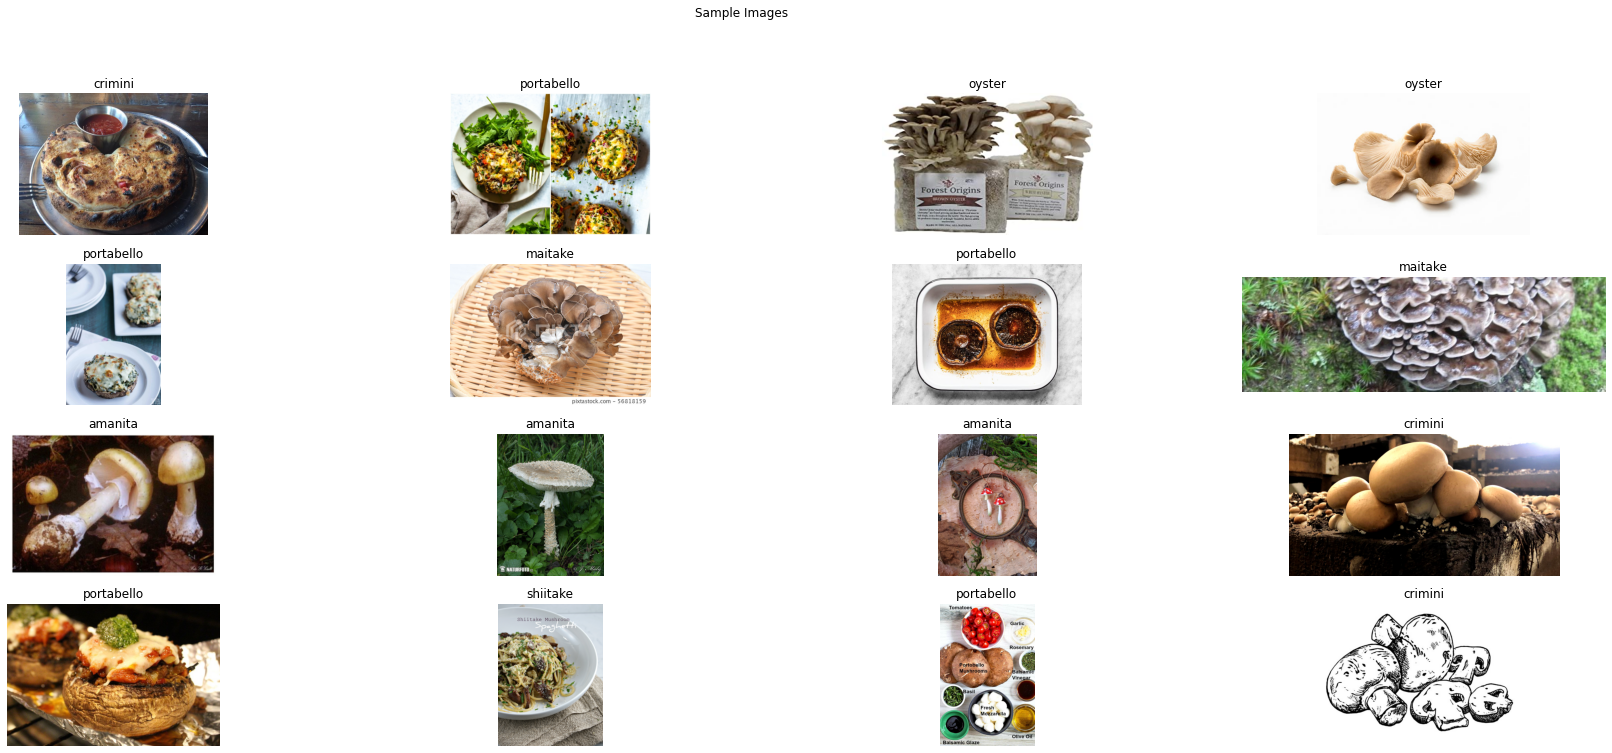

In [7]:
# Generate a random sample of index
image_samples = np.random.randint(0,high=len(data_list)-1, size=16)

fig = plt.figure(figsize=(30,12))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(4,4,i+1)
    axs.set_title(data_list[img_idx][0])
    # Read image
    image = cv2.imread(data_list[img_idx][1])
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')

plt.suptitle("Sample Images")
plt.show()

## **<font color="#A41034">Build Data Pipelines</font>**

In [26]:
image_width = 224
image_height = 224
num_channels = 3
num_output_masks = 2
batch_size = 64

In [27]:
# Your code here
def create_tf_example(item):

  # Read image
  image = tf.io.read_file(item[1])
  image = tf.image.decode_jpeg(image, channels=num_channels)
  image = tf.image.resize(image, [image_height,image_width])
  # # Encode
  # image = tf.cast(image, tf.uint8)
  # image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
  image = tf.cast(image, tf.uint8)

  # Label
  label = label2index[item[0]]

  # Build feature dict
  # this is saving the metadata for aspects of the image
  feature_dict = {
      'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image.numpy().tobytes()])),
      'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
      'width': tf.train.Feature(int64_list=tf.train.Int64List(value=[image_width])),
      'height': tf.train.Feature(int64_list=tf.train.Int64List(value=[image_height]))
  }

  example = tf.train.Example(features=tf.train.Features(feature=feature_dict))
  return example

def create_tf_records(data,num_shards=10, prefix='', folder='data'):
  num_records = len(data)
  step_size = num_records//num_shards + 1

  for i in range(0, num_records, step_size):
    print("Creating shard:",(i//step_size)," from records:",i,"to",(i+step_size))
    path = '{}/{}_000{}.tfrecords'.format(folder, prefix, i//step_size)
    print(path)

    # Write the file
    with tf.io.TFRecordWriter(path) as writer:
      # Filter the subset of data to write to tfrecord file
      for item in data[i:i+step_size]:
        tf_example = create_tf_example(item)
        writer.write(tf_example.SerializeToString()) 

In [28]:
# Your code here
validation_percent = 0.2

NUM_DUPS = 5

# Split data into train / validate
train_xy, validate_xy = train_test_split(data_list, test_size=validation_percent)

print("train_xy count:",len(train_xy))
print("validate_xy count:",len(validate_xy))

train_xy count: 2692
validate_xy count: 673


Why are we using 5*the same images? 

In [29]:
# Create an output path to store the tfrecords
tfrecords_output_dir = "mushroom_tfrecords"
if os.path.exists(tfrecords_output_dir):
  shutil.rmtree(tfrecords_output_dir)
tf.io.gfile.makedirs(tfrecords_output_dir)

# Split data into multiple TFRecord shards between 100MB to 200MB
num_shards = 10

# Create TF Records for train
start_time = time.time()
create_tf_records(train_xy,num_shards=num_shards, prefix="train", folder=tfrecords_output_dir)
execution_time = (time.time() - start_time)/60.0
print("Execution time (mins)",execution_time)

# Split data into multiple TFRecord shards between 100MB to 200MB
num_shards = 3

# Create TF Records for validation
start_time = time.time()
create_tf_records(validate_xy,num_shards=num_shards, prefix="val", folder=tfrecords_output_dir)
execution_time = (time.time() - start_time)/60.0
print("Execution time (mins)",execution_time)

Creating shard: 0  from records: 0 to 270
mushroom_tfrecords/train_0000.tfrecords
Creating shard: 1  from records: 270 to 540
mushroom_tfrecords/train_0001.tfrecords
Creating shard: 2  from records: 540 to 810
mushroom_tfrecords/train_0002.tfrecords
Creating shard: 3  from records: 810 to 1080
mushroom_tfrecords/train_0003.tfrecords
Creating shard: 4  from records: 1080 to 1350
mushroom_tfrecords/train_0004.tfrecords
Creating shard: 5  from records: 1350 to 1620
mushroom_tfrecords/train_0005.tfrecords
Creating shard: 6  from records: 1620 to 1890
mushroom_tfrecords/train_0006.tfrecords
Creating shard: 7  from records: 1890 to 2160
mushroom_tfrecords/train_0007.tfrecords
Creating shard: 8  from records: 2160 to 2430
mushroom_tfrecords/train_0008.tfrecords
Creating shard: 9  from records: 2430 to 2700
mushroom_tfrecords/train_0009.tfrecords
Execution time (mins) 0.6699924111366272
Creating shard: 0  from records: 0 to 225
mushroom_tfrecords/val_0000.tfrecords
Creating shard: 1  from reco

In [30]:
# Read TF Records
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'height': tf.io.FixedLenFeature([], tf.int64)
}

# @tf.function
def parse_tfrecord_example(example_proto):
  parsed_example = tf.io.parse_single_example(example_proto, feature_description)

  # Image
  #image = tf.image.decode_jpeg(parsed_example['image'])
  image = tf.io.decode_raw(parsed_example['image'], tf.uint8)
  image.set_shape([num_channels * image_height * image_width])
  image = tf.reshape(image, [image_height, image_width, num_channels])
  # Label
  label = tf.cast(parsed_example['label'], tf.int32)
  label = tf.one_hot(label, num_classes)

  return image, label

# Normalize pixels
def normalize(image, label):
  image = image/255
  return image, label

# performing the augmentations (based on https://www.tensorflow.org/tutorials/images/data_augmentation)
def data_augmentation(image, label):
  if tf.random.uniform(()) > 0.5:
    image = tf.image.flip_left_right(image)
  image = tf.image.adjust_contrast(image, np.random.uniform(low=0.1, high = 0.5))
  image = tf.image.adjust_hue(image, np.random.uniform(low=-0.15, high = 0.15))
  image = tf.image.adjust_brightness(image, np.random.uniform(low=-0.15, high = 0.15))

  return image, label

# Read the tfrecord files
train_tfrecord_files = tf.data.Dataset.list_files(tfrecords_output_dir+'/train*')
validate_tfrecord_files = tf.data.Dataset.list_files(tfrecords_output_dir+'/val*')

#############
# Train data
#############
train_data = train_tfrecord_files.flat_map(tf.data.TFRecordDataset)
train_data = train_data.map(parse_tfrecord_example, num_parallel_calls=AUTOTUNE)
# https://stackoverflow.com/questions/48029542/data-augmentation-in-test-validation-set
# [Data augmentation is used] only on training. Data augmentation is used to increase the size of training set and to get more different images. Technically, you could use data augmentation on test set to see how model behaves on such images, but usually people don't do it.
#train_data = train_data.map(data_augmentation, num_parallel_calls=AUTOTUNE)
train_data = train_data.map(normalize, num_parallel_calls=AUTOTUNE)
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(buffer_size=AUTOTUNE)

##################
# Validation data
##################
validation_data = validate_tfrecord_files.flat_map(tf.data.TFRecordDataset)
validation_data = validation_data.map(parse_tfrecord_example, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.map(normalize, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.prefetch(buffer_size=AUTOTUNE)

print("train_data",train_data)
print("validation_data",validation_data)

train_data <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 6)), types: (tf.float32, tf.float32)>
validation_data <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 6)), types: (tf.float32, tf.float32)>


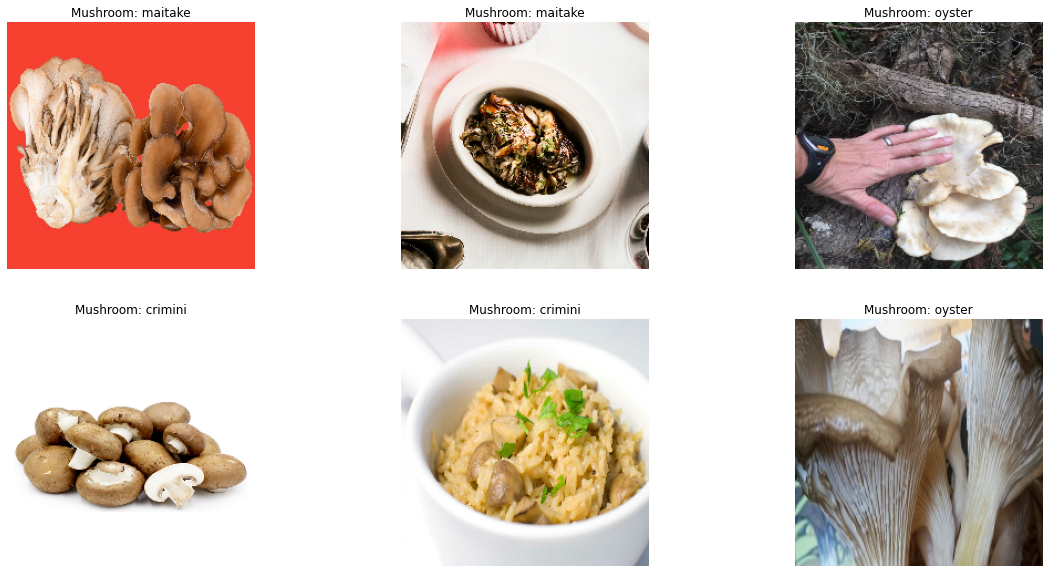

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10))

for batch in train_data.take(1):

  # get all the images and labels from the first batch
  image, label = batch

  # loop through all the axes
  for i, ax in enumerate(fig.axes):
    # print the specific image
    ax.imshow(image.numpy()[i])
    ax.axis('off')
    ax.set_title(f'Mushroom: {index2label[label.numpy()[i].argmax()]}')

plt.show()

## **<font color="#A41034">Build Image Classificaton Models</font>**

### **Create Experiment**

Use the util functions to create an experiment to keep track of hyper parameters, metrics, models etc. This will be used for your submission to the cloud storage

In [83]:
# Create an experiment
create_experiment()

In [90]:
experiment_name = '1'

### **Build Model**

In [91]:
print(image_height)
print(image_width)
print(num_channels)
print(num_classes)

224
224
3
6


In [92]:
def evaluate_model(model,test_data, model_train_history,execution_time, 
                        learning_rate, batch_size, epochs, optimizer,
                        save=True,
                        loss_metrics=["loss","val_loss"],
                        acc_metrics=["accuracy","val_accuracy"]):
    
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history[loss_metrics[0]])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in loss_metrics:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in acc_metrics:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  
  # Evaluate on test data
  evaluation_results = model.evaluate(test_data, return_dict=True)
  print(evaluation_results)

  evaluation_results = [evaluation_results[loss_metrics[0]], evaluation_results[acc_metrics[0]]]
  
  if save:
    # Save model
    save_model(model, model_train_history,execution_time, learning_rate, epochs, optimizer, evaluation_results)
  
  return evaluation_results

In [93]:
def build_teacher_model(image_height, image_width, num_channels, num_classes):

  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels

  # Handle to pretrained model (Use a different model here)
  handle = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"
  # handle = "https://tfhub.dev/tensorflow/resnet_50/feature_vector/1"

  # Regularize using L1
  kernel_weight = 0.01
  bias_weight = 0

  model = Sequential([
        keras.layers.InputLayer(input_shape=input_shape),
                                hub.KerasLayer(handle, trainable=False),
        keras.layers.Dense(units=64, activation='relu',
                           kernel_regularizer=keras.regularizers.l2(kernel_weight), 
                           bias_regularizer=keras.regularizers.l2(bias_weight)
                           ),
        keras.layers.Dense(units=num_classes,
                           kernel_regularizer=keras.regularizers.l2(kernel_weight), 
                           bias_regularizer=keras.regularizers.l2(bias_weight)),
  ],name='teacher_model')

  return model

Model: "teacher_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 2,340,358
Trainable params: 82,374
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/50
43/43 - 13s - loss: 2.4620 - categorical_accuracy: 0.5565 - val_loss: 2.0810 - val_categorical_accuracy: 0.6672
Epoch 2/50
43/43 - 7s - loss: 1.8964 - categorical_accuracy: 0.7285 - val_loss: 1.8908 - val_categorical_accuracy: 0.6999
Epoch 3/50
43/43 - 8s - loss: 1.7115 - categorical_accuracy: 0.7745 - val_loss: 1.7915 - val_categorical_accuracy: 0.7

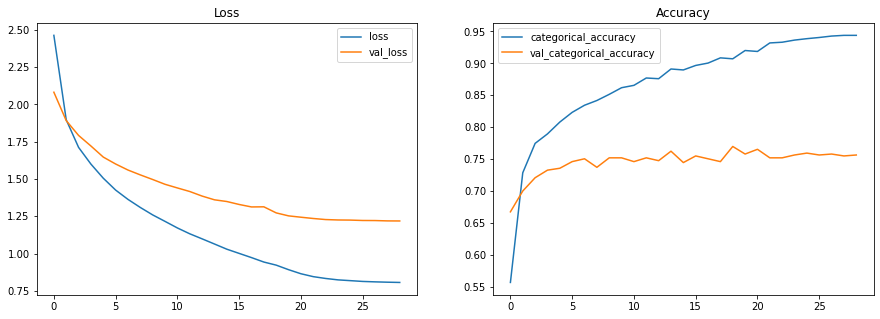

11/11 [==============================] - 2s 140ms/step - loss: 1.2725 - categorical_accuracy: 0.7697
{'loss': 1.272537350654602, 'categorical_accuracy': 0.7696879506111145}


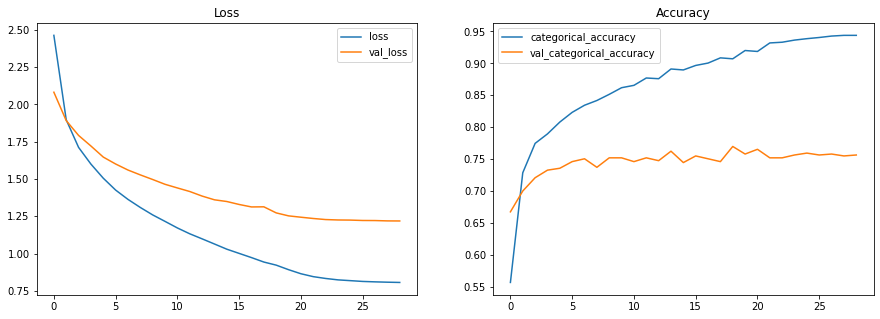

11/11 [==============================] - 2s 139ms/step - loss: 1.2725 - categorical_accuracy: 0.7697
[1.272537350654602, 0.7696879506111145]
9596376
{'trainable_parameters': 82374, 'execution_time': 4.312445143858592, 'loss': 1.272537350654602, 'accuracy': 0.7696879506111145, 'model_size': 9596376, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 50, 'optimizer': 'Adamax'}
Teacher training execution time (mins) 4.312445143858592


In [94]:
# Your Code Here
start_time = time.time()
############################
# Training Params
############################
learning_rate = 0.001
initial_epoch = 0
epochs = 50



# Free up memory
K.clear_session()

# Optimizer
optimizer = keras.optimizers.Adamax(learning_rate=learning_rate)
# Loss
# we want logits here b/c later we will tune the temperature
loss = keras.losses.CategoricalCrossentropy(from_logits=True)


# Build the teacher model
teacher_model = build_teacher_model(image_height, image_width, num_channels, num_classes)
print(teacher_model.summary())


# Callbacks
# Learning Rate Scheduler: Changes learning rates during training epochs
# we reduce the learning rate after scheduler
# we want to lessen the learning rate b/c if the learning rate is big, then it would take longer to reach the loss
# in order to avoid this jumping around, reduce the l.r. so that the steps are smaller
def scheduler(epoch, lr):
  if epoch < 20:
    return lr
  else:
    return lr * 0.7
lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)
# Early Stopping: Stop training when a monitored metric has stopped improving
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_categorical_accuracy', min_delta=0, patience=10, verbose=2, mode='auto', restore_best_weights=True
)
callbacks = [lr_scheduler, early_stopping]


# Compile
teacher_model.compile(optimizer=optimizer,
                    loss=loss,
                    metrics=[keras.metrics.CategoricalAccuracy()])

# Train model
start_time = time.time()
training_results = teacher_model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        callbacks=callbacks,
        initial_epoch=initial_epoch,
        verbose=2)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history

# Evaluate model
evaluate_model(teacher_model,validation_data, training_history,execution_time, 
                    learning_rate, batch_size, epochs, optimizer,
                    save=False,
                    loss_metrics=["loss","val_loss"],
                    acc_metrics=["categorical_accuracy","val_categorical_accuracy"])

execution_time = (time.time() - start_time)/60.0

evaluate_save_model(teacher_model,validation_data, training_history, execution_time, learning_rate, batch_size, epochs, optimizer,save=True)

print("Teacher training execution time (mins)",execution_time)

In [66]:
kernel_weight = 0.01
bias_weight = 0

def build_student_model(image_height, image_width, num_channels, num_classes, model_name='student'):
  # Model input
  input_shape = [image_height, image_width, num_channels]  # height, width, channels

  model = Sequential(
      [
        keras.Input(shape=input_shape),
        keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), padding="same",
                            kernel_initializer=keras.initializers.GlorotUniform(seed=1212), kernel_regularizer=keras.regularizers.l2(kernel_weight), 
                           bias_regularizer=keras.regularizers.l2(bias_weight)),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
        keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), padding="same", 
                            kernel_initializer=keras.initializers.GlorotUniform(seed=2121), kernel_regularizer=keras.regularizers.l2(kernel_weight), 
                           bias_regularizer=keras.regularizers.l2(bias_weight)),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
        keras.layers.Flatten(),
        keras.layers.Dense(units=32, kernel_initializer=keras.initializers.GlorotUniform(seed=2323)),
        keras.layers.Dense(units=num_classes, kernel_initializer=keras.initializers.GlorotUniform(seed=3434))
      ],
      name=model_name)

  return model

In [67]:
# this is inherting from the Tensorflow Model class
class Distiller(Model):
    def __init__(self, teacher, student):
        super(Distiller, self).__init__()
        # defining two attributes
        self.teacher = teacher
        self.student = student

    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn, Lambda = 0.1, temperature=3):
      """
      optimizer: Keras optimizer for the student weights
      metrics: Keras metrics for evaluation
      student_loss_fn: Loss function of difference between student predictions and ground-truth
      distillation_loss_fn: Loss function of difference between soft student predictions and soft teacher predictions
      lambda: weight to student_loss_fn and 1-alpha to distillation_loss_fn
      temperature: Temperature for softening probability distributions. Larger temperature gives softer distributions.
      """
      super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
      self.student_loss_fn = student_loss_fn
      self.distillation_loss_fn = distillation_loss_fn

      #hyper-parameters
      self.Lambda = Lambda
      self.temperature = temperature

    # we're overloading the train method
    def train_step(self, data):
        # Unpack data (passed as a tuple)
        x, y = data

        # Forward pass of teacher (professor)
        teacher_predictions = self.teacher(x, training=False)

        # everything within here has derivates
        # create a computational graph
        # the tape function is what is recording the partial derivatives
        with tf.GradientTape() as tape:
            # Forward pass of student
            # the derivatives will go through the prediction here
            # computing the loss 
            student_predictions = self.student(x, training=True)

            # Compute losses
            # get dY/dweights
            # look at the student loss on slide 114, lecture 4
            student_loss = self.student_loss_fn(y, student_predictions)
            # getting -Ylog(P), where Y is from the teacher and P is from the student
            # find the loss difference between the loss 
            # look at the distillation loss on slide 114, lecture 4
            # we've defined this distillation loss here as CategoricalCrossEntropy
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            # WE ARE USING THIS HERE TO PERFORM THE ADJUSTMENTS
            loss = self.Lambda * student_loss + (1 - self.Lambda) * distillation_loss

        # Compute gradients
        # take all the weights of the student, and take the derivatives of that w.r.t the trainable variables
        trainable_vars = self.student.trainable_variables
        # SEE HOW WE'RE USING THE WEIGHTS HERE
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        '''We're not taking derivatives here, just the forward step'''

        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [68]:
model_name = f'student_distill_{time.time()}' 

Model: "student_distill_1633396132.251104"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 16)      448       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 112, 112, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (Non

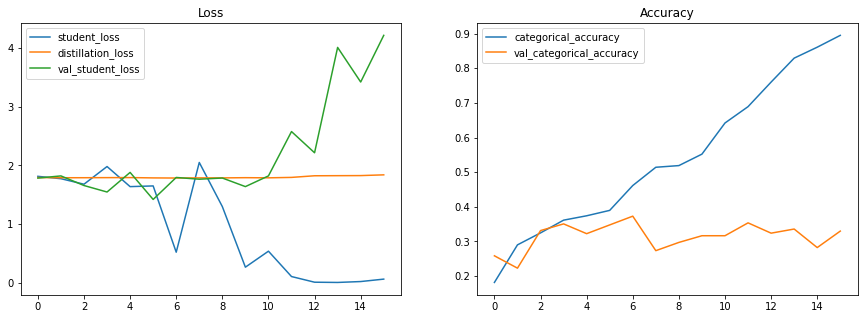

11/11 [==============================] - 1s 47ms/step - categorical_accuracy: 0.3477 - student_loss: 1.6380
{'categorical_accuracy': 0.34769687056541443, 'student_loss': 1.4678808450698853}


In [69]:
############################
# Training Params
############################
learning_rate = 0.01
# epochs = 10
epochs = 25
# epochs = 2
Lambda = 0.75
temperature= 12

# Free up memory
K.clear_session()

# Build Student model
# only logits, no softmax
student_model = build_student_model(image_height, image_width, num_channels, num_classes, model_name=model_name)
print(student_model.summary())

# Build the distiller model
# teacher will be the one defined a couple cells ago, the student is from the one defined four lines above
distiller_model = Distiller(teacher=teacher_model, student=student_model)

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
student_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
# this is another loss divergence that can be used
#distillation_loss = keras.losses.KLDivergence()
distillation_loss = keras.losses.CategoricalCrossentropy(from_logits=False)


# Callbacks
# Learning Rate Scheduler: Changes learning rates during training epochs
# we reduce the learning rate after scheduler
# we want to lessen the learning rate b/c if the learning rate is big, then it would take longer to reach the loss
# in order to avoid this jumping around, reduce the l.r. so that the steps are smaller
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * 0.999
lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)
# Early Stopping: Stop training when a monitored metric has stopped improving
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_student_loss', min_delta=0, patience=10, verbose=2, mode='auto', restore_best_weights=True
)
callbacks = [lr_scheduler,early_stopping]

# Compile
distiller_model.compile(
    optimizer=optimizer,
    student_loss_fn=student_loss,
    distillation_loss_fn=distillation_loss,
    metrics=[keras.metrics.CategoricalAccuracy()], # keras.metrics.Accuracy() is going to give all zero values
    Lambda=Lambda,
    temperature=temperature
)

# Distill teacher to student
start_time = time.time()
training_results = distiller_model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        callbacks=callbacks,
        verbose=2)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history

# Evaluate model
evaluation_results = evaluate_model(distiller_model,validation_data, 
               training_history,execution_time,learning_rate, batch_size, epochs, optimizer,
               save=False,
               loss_metrics=["student_loss","distillation_loss","val_student_loss"],
               acc_metrics=["categorical_accuracy","val_categorical_accuracy"])

# Save student model
save_model(student_model,training_history,execution_time,learning_rate, epochs, optimizer, evaluation_results)

### **Train**

In [65]:
print(type(student_model))

<class 'keras.engine.sequential.Sequential'>


/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "student_distill_1633396132.251104"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv2d ( (None, 112, 112, 16)      882       
_________________________________________________________________
prune_low_magnitude_leaky_re (None, 112, 112, 16)      1         
_________________________________________________________________
prune_low_magnitude_max_pool (None, 56, 56, 16)        1         
_________________________________________________________________
prune_low_magnitude_conv2d_1 (None, 28, 28, 32)        9250      
_________________________________________________________________
prune_low_magnitude_leaky_re (None, 28, 28, 32)        1         
_________________________________________________________________
prune_low_magnitude_max_pool (None, 14, 14, 32)        1         
_________________________________________________________________
prune_low_magnitude_flatten  (Non

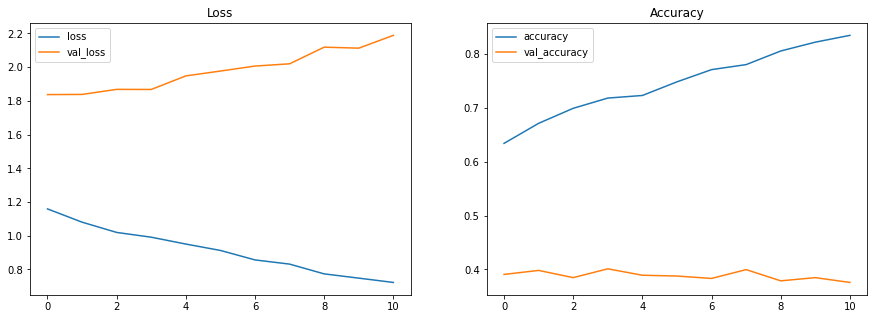

11/11 [==============================] - 1s 47ms/step - loss: 1.8371 - accuracy: 0.3908
[1.8370896577835083, 0.3907875120639801]
1685976
{'trainable_parameters': 206022, 'execution_time': 0.7871288379033407, 'loss': 1.8370896577835083, 'accuracy': 0.3907875120639801, 'model_size': 1685976, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 50, 'optimizer': 'Adam'}


In [103]:
# Define model for pruning
# epochs = 5
# epochs = 10
epochs = 50
# epochs = 2
end_step = np.ceil(len(train_xy) / batch_size).astype(np.int32) * epochs

pruning_params = {
    # we are saying the final sparsity must be 80%
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}
# `prune_low_magnitude` can only prune an object of the following types: tf.keras.models.Sequential, tf.keras functional model, tf.keras.layers.Layer, list of tf.keras.layers.Layer. You passed an object of type: Distiller.
# YOU'RE PASSING INTO THE PRUNING MODEL HERE
model_for_pruning = prune_low_magnitude(student_model, **pruning_params)

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = keras.losses.CategoricalCrossentropy(from_logits=True)
# Compile
# ADDING IN THE ACCURACY INTO THIS STEP
model_for_pruning.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=[keras.metrics.CategoricalAccuracy(name='accuracy')])

model_for_pruning.summary()

# Early Stopping: Stop training when a monitored metric has stopped improving
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=2, mode='auto', restore_best_weights=True
)

# Callback

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  early_stopping
]

start_time = time.time()
training_results = model_for_pruning.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

####################################
##### Use this code to Save ########
####################################
# Get model training history
training_history = training_results.history
# Evaluate and save the model details


evaluate_save_model(model_for_pruning ,validation_data, training_history,execution_time, 
                    learning_rate, batch_size, epochs, optimizer,
                    save=True)

### Get the model back after pruning

In [102]:
experiment_name='2'

In [104]:
# get model back after pruning
# Get the model back after pruning
after_prune = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
after_prune.summary()

Model: "student_distill_1633396132.251104"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 16)      448       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 112, 112, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (Non

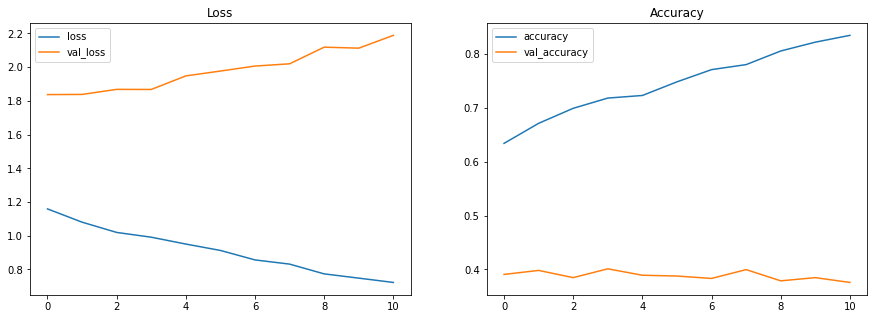

11/11 [==============================] - 1s 45ms/step - loss: 1.8371 - accuracy: 0.3908
[1.8370896577835083, 0.3907875120639801]
846688
{'trainable_parameters': 206022, 'execution_time': 0.7871288379033407, 'loss': 1.8370896577835083, 'accuracy': 0.3907875120639801, 'model_size': 846688, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 50, 'optimizer': 'Adam'}


In [105]:
# Get model training history
training_history = training_results.history

# Compile
after_prune.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=[keras.metrics.CategoricalAccuracy(name='accuracy')])

# Evaluate model
evaluate_save_model(after_prune,validation_data, training_history,execution_time, 
               learning_rate, batch_size, epochs, optimizer,
               save=True)

## **<font color="#A41034">Experiment Results</font>**

#### **Compare Models**

In [106]:
models_metrics_list = glob(experiment_name+"/*_model_metrics.json")

all_models_metrics = []
for mm_file in models_metrics_list:
  with open(mm_file) as json_file:
    model_metrics = json.load(json_file)
    model_metrics["name"] = mm_file.replace(experiment_name+"/","").replace("_model_metrics.json","")
    all_models_metrics.append(model_metrics)

# Load metrics to dataframe
view_metrics = pd.DataFrame(data=all_models_metrics)

# Format columns
view_metrics['accuracy'] = view_metrics['accuracy']*100
view_metrics['accuracy'] = view_metrics['accuracy'].map('{:,.2f}%'.format)

view_metrics['trainable_parameters'] = view_metrics['trainable_parameters'].map('{:,.0f}'.format)
view_metrics['execution_time'] = view_metrics['execution_time'].map('{:,.2f} mins'.format)
view_metrics['loss'] = view_metrics['loss'].map('{:,.2f}'.format)
view_metrics['model_size'] = view_metrics['model_size']/1000000
view_metrics['model_size'] = view_metrics['model_size'].map('{:,.0f} MB'.format)

view_metrics = view_metrics.sort_values(by=['accuracy'],ascending=False)
view_metrics.head(10)

,trainable_parameters,execution_time,loss,accuracy,model_size,learning_rate,batch_size,epochs,optimizer,name
0,"206,022",0.79 mins,1.84,39.08%,1 MB,0.001,64,50,Adam,student_distill_1633396132.251104


## **<font color="#A41034">Upload Experiment to Cloud Storage</font>**

### **Login using Google Acccount**

In [96]:
# Authenticate
auth.authenticate_user()

### **Save Experiment**

In [97]:
# Save data details used for the experiment
data_details = {
  "image_width": image_width,
  "image_height": image_height,
  "num_channels": num_channels,
  "num_classes": num_classes,
  "label2index": label2index,
  "index2label": index2label
}

# Upload experiment to cloud storage
upload_experiment(data_details)

user_account davidassaraf@g.harvard.edu
Model Bucket: <Bucket: ac215-mushroom-app-models>
1/teacher_model.json
uploading file 1/teacher_model.json
1/data_details.json
uploading file 1/data_details.json
1/teacher_model_train_history.json
uploading file 1/teacher_model_train_history.json
1/teacher_model.h5
uploading file 1/teacher_model.h5
1/teacher_model.hdf5
uploading file 1/teacher_model.hdf5
1/teacher_model_model_metrics.json
uploading file 1/teacher_model_model_metrics.json
Uploading file submit.txt
